# Fourier harmonics

The Fourier harmonics module offers tools to extract the individual frequencies from the multiperiodic content of time series, to perform multiple-frequency fits and to derive Fourier parameters.

It has two main options:

- The `MultiHarmonicFitter` is used to extract the parameters of the main frequency with the highest peak in the spectrum and its harmonics and to simultaneously fit those Fourier components to a time series. The derived components are the base of the Fourier parameter calculations.

- The `MultiFrequencyFitter` extracts the parameters of all frequency components above a given threshold with pre-whitening steps in decreasing amplitude order.

## Choosing the type of Fourier series

The Fourier series fit can be done via two ways. Fitting $sine$ or $cosine$ functions:

 $$ \sum_i A_i sin( 2\pi f_i t + \phi_i ) + constant ,$$

 $$ \sum_i A_i cos( 2\pi f_i t + \phi_i ) + constant ,$$

 where $A_i$ is the semi-amplitude, $f_i$ is the frequency and $\phi_i$ is the phase of the given component. The _constant_ is the zero point of the light curve.

__Note:__ This is __optional in the code__. Use the keyword `kind='sin'` or `kind='cos'` to select one. The default is _sine_.

__The code first finds the frequency with the highest peak in the spectrum__ and after that does a consequtive pre-whitening with the integer multiples of that frequency. Thus, if we want to calculate the Fourier parameters of e.g. the second overtone, we have to put constraints on the frequency range to be checked i.e. `minimum_frequency` and `maximum_frequency` must be defined. Otherwise the highest peak in the spectrum will be considered.

__Note:__ If due to sparse sampling the __Nyquist limit is low (e.g. in case of ground-based observations)__, set `maximum_frequency` to overwrite the default Nyquist limit.

## Fourier parameters

After fitting ___at least___ 3 frequencies, the Fourier parameters can be calculated as

 $$ R_{21} = \frac{A_2}{A_1} ,$$
 $$ R_{31} = \frac{A_3}{A_1} ,$$
 $$ \phi_{21} = \phi_2 - 2 \phi_1 ,$$
 $$ \phi_{31} = \phi_3 - 3 \phi_1 ,$$

 which values __depend on__ the ___chosen function (sine or cosine)___, the ___physical units (flux or mag)___ and the passband as well. The more the harmonics, the more accurate the results.
 
__Note:__ To get all harmonics, set `nfreq` to a very large number (e.g. 9999), which case the number of harmonincs will be limited by the signal-to-noise ratio.

## Error estimation

Errors are estimated analytically by default using the formulae of [Breger (1999, A&A, 349, 225)](https://ui.adsabs.harvard.edu/abs/1999A%26A...349..225B/abstract):

 $$ \sigma(f) = \sqrt{\frac{6}{N}} \frac{1}{\pi T} \frac{\sigma(m)}{a} ,$$
 $$ \sigma(a) = \sqrt{\frac{2}{N}} \sigma(m) ,$$
 $$ \sigma(\phi) = \sqrt{\frac{1}{2\pi}} \sqrt{\frac{2}{N}} \frac{\sigma(m)}{a} .$$

However, __errors__ can also be estimated in two other, more reliable ways.

 - Set `error_estimation` to `'bootstrap'` to enable the bootstrap method.
 
 - Or set `error_estimation` to `'montecarlo'` to enable the monte carlo method.
 
Both methods generate new light curves `ntry` times and fit each dataset induvidually. The results are collected and the parameter uncertenties are estimated from the distributions.

___Bootstraping:___

To generate new data sets the _bootstrap_ method subsamples the light curve. The number of sampled points are controlled by the `sample_size` (= ratio between 0-1) parameter.
 
___Monte Carlo sampling:___ 

The _monte carlo_ method generates light curves with the same number of points as the original number of points. Each brightness measurement is resampled from a Gaussian with mean equals to the original brightness and std equals to the noise. If light curves noise is not known, then it is estimated from the residual light curve.
 
To speed up the sampling process, the code can be run parallel via setting `parallel` to `True`. By deafult, all the CPU cores are used, but this can be limited by setting `ncores`.
 
__Note:__ The resulted distributions and their correlations can be visualized by setting `plotting` to `True`. However, to decouple the frequencies from the phases the time points are constrained by
 
 $$ \sum_i t_i = 1 $$

Thus, the absolute values of the plotted phases will differ from the returned ones. They are only used to estimate errors.

## __How to use__

In [1]:
from seismolab.fourier import MultiHarmonicFitter, MultiFrequencyFitter

import numpy as np
import matplotlib.pyplot as plt

We load as an example the light curve of ST Pic from TESS Setor 1.

In [2]:
lc = np.loadtxt("https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:HLSP/qlp/s0001/0000/0001/5016/6721/hlsp_qlp_tess_ffi_s0001-0000000150166721_tess_v01_llc.txt", delimiter=',').T

# Store results in separate arrays for clarity
time       = lc[0]
brightness = lc[1]

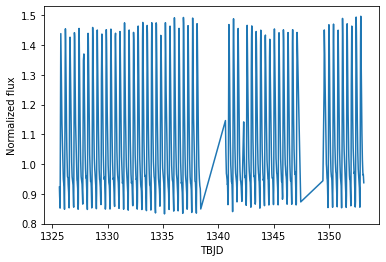

In [3]:
plt.plot(time, brightness)
plt.xlabel("TBJD")
plt.ylabel("Normalized flux")
plt.show()

### Extracting the main frequency and its harmonics

We initialize the `MultiHarmonicFitter` by passing the light curve. Passing the measurement errors is optional, but it strongly affects the results!

In [4]:
fitter = MultiHarmonicFitter(time,brightness)

# The same can be done with measurement errors
#fitter = MultiHarmonicFitter(time,brightness,brightness_error)

__The spectral window can be used to filter alias peaks in the spectrum.__

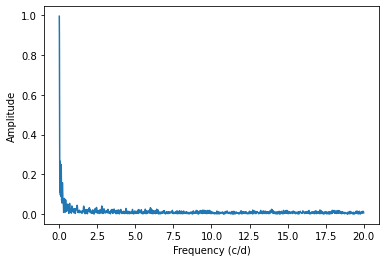

In [5]:
swf,swp = fitter.get_spectral_window(maximum_frequency=20)

plt.plot(swf,swp)
plt.xlabel("Frequency (c/d)")
plt.ylabel("Amplitude")
plt.show()

__Prewhitening with given number of harmonics are done via `fit_harmonics`.__

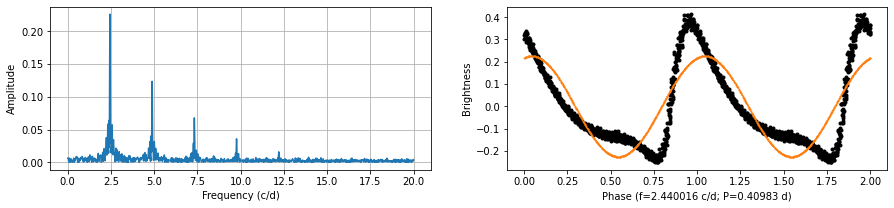

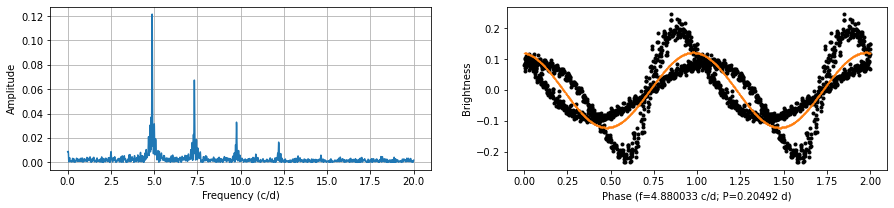

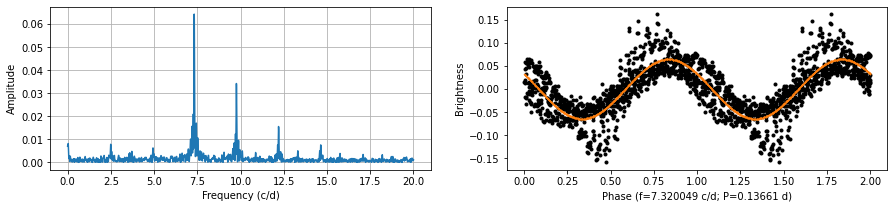

In [6]:
pfit,perr = fitter.fit_harmonics(
    maxharmonics = 3,            # Set to e.g. 9999 to fit all harmonics
    kind='sin',                  # Fourier series type, 'sin' or 'cos'

    minimum_frequency=None,
    maximum_frequency=20,        # Overwrites nyquist_factor!
    nyquist_factor=1,
    samples_per_peak=100,        # Oversampling factor in Lomb-Scargle spectrum calculation

    plotting = True,             # Show spectrum and phase curve
    scale='flux',                # Light curve scale, `mag` or `flux`

    error_estimation='analytic', # Method of the error estimation
    ntry=1000,                   # Number of samplings if method is NOT `analytic`
    sample_size=0.999,           # Subsample size if method is `bootstrap`
    parallel=True,               # Parallel sampling if method is NOT `analytic`
    ncores=-1,                   # Number of cores if method is NOT `analytic`
    
    best_freq=None               # Use this frequency for the basis of the Fourier harmonics
                                 # This option overwrites the automatic Lomb-Scargle frequency search
)

The results and its errors are stored in two arrays, in the following order:

- the main frequency in cycle/days,
- the amplitudes and phases of the main frequency and its harmonics,
- the zero point.

These can be printed e.g. as follows:

In [7]:
print('Freq = %.6f +/- %.6f' % (pfit[0], perr[0]) )

ncomponents = int((len(pfit)-1)/2)

for i in range(1, ncomponents + 1 ):
    print('A%d   = %.6f +/- %.6f' % (i, pfit[i],             perr[i]) )
    print('Phi%d = %.6f +/- %.6f' % (i, pfit[i+ncomponents], perr[i+ncomponents]) )
    
print('Zero point = %.2f +/- %.2f' % (pfit[-1], perr[-1]) )

Freq = 2.058955 +/- 0.000052
A1   = 0.115327 +/- 0.000299
Phi1 = 2.026542 +/- 0.000412
A2   = 0.046095 +/- 0.000299
Phi2 = 3.995341 +/- 0.001031
A3   = 0.019665 +/- 0.000299
Phi3 = 6.163637 +/- 0.002416
Zero point = 1.00 +/- 0.03


__The Fourier parameters can be calculated as follows.__

The results are `uncertainties`. The first two returned values are the main frequency and period with their errors, in cycle/days and days, respectively. The last two values are lists containing the $R_{n1}$, $\Phi_{n1}$ Fourier parameters. 

In [8]:
freq, period, Rn1, Phin1 = fitter.get_fourier_parameters()

In [9]:
print('Freq   = %.6f +/- %.6f' % (freq.n,   freq.s) )
print('Period = %.6f +/- %.6f'%  (period.n, period.s) )

for i,(Rn,Phin) in enumerate(zip(Rn1,Phin1)):
    print('R%d1   = %.3f +/- %.3f' % ((i+2), Rn.n,   Rn.s) )
    print('Phi%d1 = %.3f +/- %.3f' % ((i+2), Phin.n, Phin.s) )

Freq   = 2.058955 +/- 0.000052
Period = 0.485683 +/- 0.000012
R21   = 0.400 +/- 0.003
Phi21 = 6.225 +/- 0.001
R31   = 0.171 +/- 0.003
Phi31 = 0.084 +/- 0.003


__The fitted sum of Fourier harmonincs can be reconstructed and visualized.__

In [10]:
tmodel = np.linspace(time.min(),time.max(),10000)

lcmodel = fitter.lc_model(tmodel,*pfit)

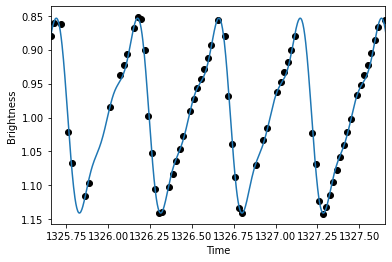

In [11]:
plt.scatter(time,brightness,c='k')
plt.plot(tmodel,lcmodel)
plt.xlim(time.min(),time.min()+2)
plt.gca().invert_yaxis()
plt.xlabel("Time")
plt.ylabel("Brightness")
plt.show()

__The residual light curve can also be easily constructed.__

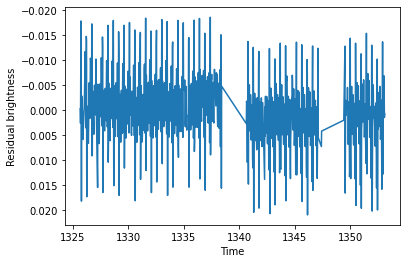

In [12]:
try:
    time, resbrightness, resyerr = fitter.get_residual()
except ValueError:
    time, resbrightness = fitter.get_residual()

plt.plot(time,resbrightness)
plt.gca().invert_yaxis()
plt.xlabel("Time")
plt.ylabel("Residual brightness")
plt.show()

### Extracting all frequencies

We initialize the `MultiFrequencyFitter` by passing the light curve. Passing the measurement errors is optional, but it strongly affects the results!

In [13]:
fitter = MultiFrequencyFitter(time,brightness)

# The same can be done with measurement errors
#fitter = MultiFrequencyFitter(time,brightness,brightness_error)

__The spectral window can be used to filter alias peaks in the spectrum.__

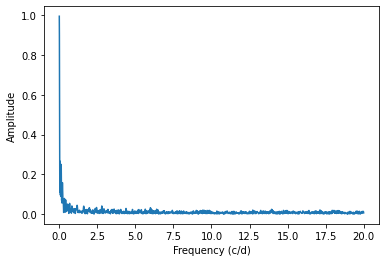

In [14]:
swf,swp = fitter.get_spectral_window(maximum_frequency=20)

plt.plot(swf,swp)
plt.xlabel("Frequency (c/d)")
plt.ylabel("Amplitude")
plt.show()

__Prewhitening with given number of frequencies are done via `fit_freqs`.__

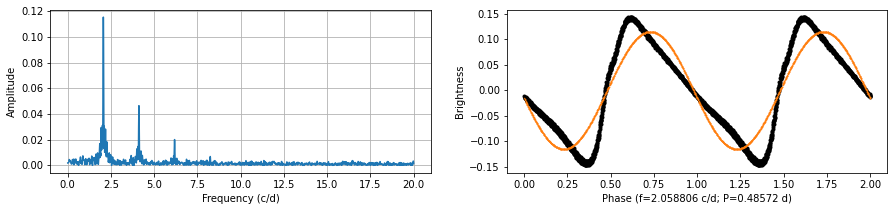

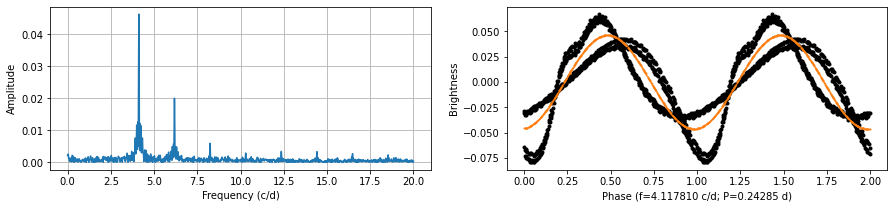

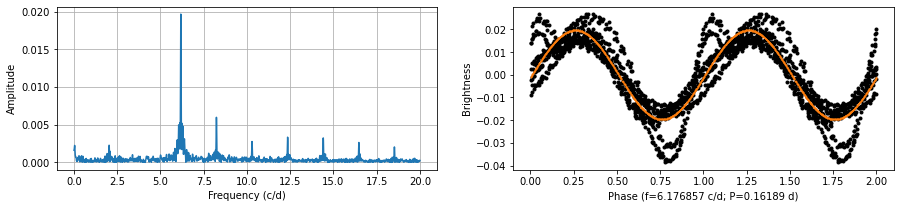

In [15]:
pfit,perr = fitter.fit_freqs(
    maxfreqs = 3,                # Set to e.g. 9999 to get all frequencies
    sigma = 4,                   # S/N ratio above which a frequency is considered significant
    kind='sin',                  # Fourier series type, 'sin' or 'cos'

    minimum_frequency=None,
    maximum_frequency=20,        # Overwrites nyquist_factor!
    nyquist_factor=1,
    samples_per_peak=100,        # Oversampling factor in Lomb-Scargle spectrum calculation

    plotting = True,             # Show spectrum and phase curve
    scale='flux',                 # Light curve scale, `mag` or `flux`

    error_estimation='analytic', # Method of the error estimation
    ntry=1000,                   # Number of samplings if method is NOT `analytic`
    sample_size=0.999,           # Subsample size if method is `bootstrap`
    parallel=True,               # Parallel sampling if method is NOT `analytic`
    ncores=-1                    # Number of cores if method is NOT `analytic`
)

The results and its errors are stored in two arrays, in the following order:

- the frequencies in cycle/days,
- the amplitudes and phases,
- the zero point.

These can be printed e.g. as follows:

In [16]:
ncomponents = int((len(pfit)-1)//3)

for i in range(ncomponents):
    print('f%d   = %.6f %.6f' % ((i+1),  pfit[i],               perr[i]) )
    print('A%d   = %.6f %.6f' % ((i+1),  pfit[i+ncomponents],   perr[i+ncomponents]) )
    print('Phi%d = %.6f %.6f' % ((i+1), pfit[i+2*ncomponents], perr[i+2*ncomponents]) )
    
print('Zero point = %.3f %.3f' % (pfit[-1], perr[-1]) )

f1   = 2.058971 0.000052
A1   = 0.115325 0.000299
Phi1 = 1.892478 0.000412
f2   = 4.117866 0.000130
A2   = 0.046097 0.000299
Phi2 = 4.363075 0.001031
f3   = 6.176849 0.000305
A3   = 0.019664 0.000299
Phi3 = 0.010573 0.002416
Zero point = 0.998 0.032


__The fitted sum of all derived frequncies can be reconstructed and visualized.__

In [17]:
tmodel = np.linspace(time.min(),time.max(),10000)

lcmodel = fitter.lc_model(tmodel,*pfit)

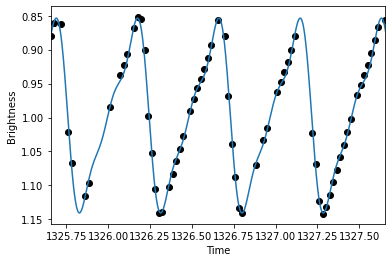

In [18]:
plt.scatter(time,brightness,c='k')
plt.plot(tmodel,lcmodel)
plt.xlim(time.min(),time.min()+2)
plt.gca().invert_yaxis()
plt.xlabel("Time")
plt.ylabel("Brightness")
plt.show()

__The residual light curve can also be easily constructed.__

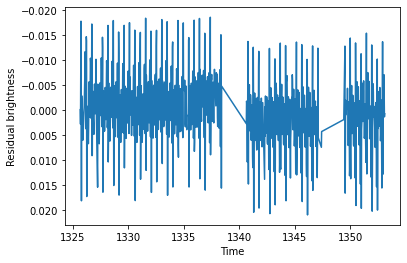

In [19]:
try:
    time, resbrightness, resyerr = fitter.get_residual()
except ValueError:
    time, resbrightness = fitter.get_residual()

plt.plot(time,resbrightness)
plt.gca().invert_yaxis()
plt.xlabel("Time")
plt.ylabel("Residual brightness")
plt.show()